## 0.0 Notebook Setup

In [1]:
#!pip install fairtorch

In [2]:
#from fairtorch import ConstraintLoss, DemographicParityLoss, EqualiedOddsLoss
import random
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import os
import torch
from torch import nn
from torch.nn import functional as F

## 1.0 Code for Regularizers

Ref -> [fairtorch repo](https://github.com/wbawakate/fairtorch/tree/master/fairtorch) in the constraint.py file. 

###1.1 MIE424 Code

In [3]:
import torch
from torch import nn
from torch.nn import functional as F


class ConstraintLoss(nn.Module):
    def __init__(self, n_class=2, alpha=1, p_norm=2):
        super(ConstraintLoss, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.alpha = alpha
        self.p_norm = p_norm
        self.n_class = n_class
        self.n_constraints = 2
        self.dim_condition = self.n_class + 1
        self.M = torch.zeros((self.n_constraints, self.dim_condition))

    #NOTE!!! --> We never call the parent mu_f in super so it was removed

    def forward(self, X, out, sensitive, y=None):
        # Reshapes sensitive attribute tensor to the same shape as the output 
        sensitive = sensitive.view(out.shape)
        # Reshapes y (label) tensor to the same shape as the output 
        if isinstance(y, torch.Tensor):
            y = y.view(out.shape)

        #Take the sigmoid of 'out' which is the output of our model (aka the weights). 
        out = torch.sigmoid(out)

        # Get the mu_f value given these tensors by calling the subclass mu_f
        #mu_f is the expected value of a sensitive feature in DP
        # print("super forward -> sub-class mu_f called")
        mu = self.mu_f(X=X, out=out, sensitive=sensitive, y=y)
        
        # Gap constraint refers to the difference beteween the two sensitive classes as calculated by taking the .mv (dot product)
        # Apply relu to matrix vector product of M and mu which 
        # Using cuda if applicable (self.device references)
        gap_constraint = F.relu(
            torch.mv(self.M.to(self.device), mu.to(self.device))
        )
        # print("super forwad -> M*mu gap constraints")

        # Using the L2 Norm of the gap constraint as regularizer with alpha parameter. 
        if self.p_norm == 2:
            cons = self.alpha * torch.dot(gap_constraint, gap_constraint)
        else:
            cons = self.alpha * torch.dot(gap_constraint.detach(), gap_constraint)
        return cons

class EqualizedOddsLoss(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity
        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.

            equalized odds: pr(y_hat | A=a, Y=y) = pr(y_hat | Y=y) for all a in A, y in Y.
            pr(y_hat =1 | A=a1, Y=y) = pr(y_hat =1 | A=a2, Y=y) for all y
        """
        self.sensitive_classes = sensitive_classes
        self.y_classes = [0, 1] # binary classification
        self.n_class = len(sensitive_classes)
        self.n_y_class = len(self.y_classes)
        super(EqualizedOddsLoss, self).__init__(n_class=self.n_class, alpha=alpha, p_norm=p_norm)
        # K:  number of constraint : (|A| x |Y| x {+, -})
        self.n_constraints = self.n_class * self.n_y_class
        # J : dim of conditions  : ((|A|+1) x |Y|)
        self.dim_condition = self.n_class* self.n_y_class
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        # print(self.M)
        #hard coded M matrix
        for i in range(self.n_constraints):
              if i==0:
                self.M[i, i] = 1.0
                self.M[i, i+2] = -1.0
              elif i == 1:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==2:
                self.M[i, i-1] = -1.0
                self.M[i, i+1] = 1.0
              elif i==3:
                self.M[i, i-2] = 1.0
                self.M[i, i] = -1.0
        print(self.M)
                
    def mu_f(self, X, out, sensitive, y):
        expected_values_list = []
        # print(self.sensitive_classes)
        # print(self.y_classes)
        for u in self.sensitive_classes:
            for v in self.y_classes:
                # print("HERE")
                idx_true = (y == v) * (sensitive == u)  # torch.bool
                expected_values_list.append(out[idx_true].mean())
        # print(expected_values_list)
        # print("Loop")
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y):
        return super(EqualizedOddsLoss, self).forward(X, out, sensitive, y=y)


##fairTorch

In [4]:
class EqualizedOddsLossOLD(ConstraintLoss):
    def __init__(self, sensitive_classes=[0, 1], alpha=1, p_norm=2):
        """loss of demograpfhic parity
        Args:
            sensitive_classes (list, optional): list of unique values of sensitive attribute. Defaults to [0, 1].
            alpha (int, optional): [description]. Defaults to 1.
            p_norm (int, optional): [description]. Defaults to 2.

            equalized odds: pr(y_hat | A=a, Y=y) = pr(y_hat | Y=y) for all a in A, y in Y.
            pr(y_hat =1 | A=a1, Y=y) = pr(y_hat =1 | A=a2, Y=y) for all y
        """
        self.sensitive_classes = sensitive_classes
        self.y_classes = [0, 1] # binary classification
        self.n_class = len(sensitive_classes)
        self.n_y_class = len(self.y_classes)
        super(EqualizedOddsLossOLD, self).__init__(n_class=self.n_class, alpha=alpha, p_norm=p_norm)
        # K:  number of constraint : (|A| x |Y| x {+, -})
        self.n_constraints = self.n_class * self.n_y_class * 2 
        # J : dim of conditions  : ((|A|+1) x |Y|)
        self.dim_condition = self.n_y_class * (self.n_class + 1)
        self.M = torch.zeros((self.n_constraints, self.dim_condition))
        # make M (K * J): (|A| x |Y| x {+, -})  *   (|A|+1) x |Y|) )
        self.c = torch.zeros(self.n_constraints)
        element_K_A = self.sensitive_classes + [None]
        for i_a, a_0 in enumerate(self.sensitive_classes):
            for i_y, y_0 in enumerate(self.y_classes):
                for i_s, s in enumerate([-1, 1]):
                    for j_y, y_1 in enumerate(self.y_classes):
                        for j_a, a_1 in enumerate(element_K_A):
                            i = i_a * (2 * self.n_y_class) + i_y * 2 + i_s
                            j = j_y + self.n_y_class * j_a
                            self.M[i, j] = self.__element_M(a_0, a_1, y_1, y_1, s)
    def __element_M(self, a0, a1, y0, y1, s):
        if a0 is None or a1 is None:
            x = y0 == y1
            return -1 * s * x
        else:
            x = (a0 == a1) & (y0 == y1)
            return s * float(x)

    def mu_f(self, X, out, sensitive, y):
        expected_values_list = []
        for u in self.sensitive_classes:
            for v in self.y_classes:
                idx_true = (y == v) * (sensitive == u)  # torch.bool
                expected_values_list.append(out[idx_true].mean())
        # sensitive is star
        for v in self.y_classes:
            idx_true = y == v
            expected_values_list.append(out[idx_true].mean())
        return torch.stack(expected_values_list)

    def forward(self, X, out, sensitive, y):
        return super(EqualizedOddsLossOLD, self).forward(X, out, sensitive, y=y)

## 2.0 Prep Artificial Dataset

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
n_samples = 512
#Answer changes when n_feature changes - I believe this is because it is still classifying over all features even though sensi_feat is just 0,1
#This is supported by the fact that more features = higher accuracy
#Because accuracy and fairness are both in the objective it makes sense our gap will be affected as the model balances the trade off of acc and gap. 
n_feature = 6
seed_everything(2020)
def generate_data(n_samples = n_samples, n_feature=n_feature):

    y = np.random.randint(0, 2, size=n_samples)
    loc0 = np.random.uniform(-1, 1, n_feature)
    loc1 = np.random.uniform(-1, 1, n_feature)

    X = np.zeros((n_samples, n_feature))
    for i, u in enumerate(y):
        #Randomly samply around the mean loc
        if y[i] ==0:
            X[i] = np.random.normal(loc = loc0, scale=1.0, size=n_feature)  
        else:
            X[i] = np.random.normal(loc = loc1, scale=1.0, size=n_feature)  

    #set feature as 1 if > mean of ALL data and 0 otherwise
    sensi_feat = (X[:, 0] > X[:, 0].mean()).astype(int)
    X[:, 0] = sensi_feat.astype(np.float32)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    sensi_feat = torch.from_numpy(sensi_feat)
    return X, y, sensi_feat

dataset = generate_data(1024)
# data split
n_train = int(0.7*len(dataset[0]))
X_train, y_train, sensi_train = map(lambda x : x[:n_train], dataset)
X_test, y_test, sensi_test = map(lambda x : x[n_train:], dataset)
print(sensi_train.size()) #feature
print(X_train.size()) #data
print(y_train.size()) #classification

torch.Size([716])
torch.Size([716, 6])
torch.Size([716])


##3.0 Main

In [7]:
def TrainModel(n_steps, dim_hidden, model, criterion, optimizer, add_loss):

  for i in range(n_steps):
      optimizer.zero_grad()    
      logit = model(X_train) #set of output probabilities [716,1] same as "out" in later function calls
      loss = criterion(logit.view(-1), y_train)
      if add_loss != None:
        loss +=  add_loss.forward(X_train, logit, sensi_train, y_train) 
      loss.backward()
      optimizer.step()
  y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()

  acc_test = (y_pred  == y_test ).float().mean().float().item()
  
  gap_eo = np.abs(y_pred[sensi_test==0].mean().item() - y_pred[sensi_test==1].mean().item())

  return y_pred, acc_test, gap_eo

In [8]:
# seed_everything(2020)
n_steps=200
dim_hidden = 32
model = nn.Sequential(nn.Linear(n_feature,1))
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)


vanilla_y_pred, vanilla_acc_test, vanilla_gap_dp = TrainModel(n_steps, dim_hidden, model, criterion, optimizer, None)
print("Vanilla: Accuracy = "+ str(round(vanilla_acc_test,3)) + ": Gap = " + str(round(vanilla_gap_dp,3)) +"\n")

print("EO:")
eo_loss_fTorch = EqualizedOddsLossOLD(sensitive_classes=[0, 1], alpha=100) # ORIGINCAL
eo_loss = EqualizedOddsLoss(sensitive_classes=[0, 1], alpha=100) # constraint

fTorch_y_pred, fTorch_acc_test, fTorch_gap_eo = TrainModel(n_steps,dim_hidden, model, criterion, optimizer, eo_loss_fTorch)
y_pred, acc_test, gap_eo = TrainModel(n_steps,dim_hidden, model, criterion, optimizer, eo_loss)
print("fTorch: Accuracy = "+ str(round(fTorch_acc_test,3)) + ": Gap = " + str(round(fTorch_gap_eo,3)))
print("MIE424: Accuracy = "+ str(round(acc_test,3)) + ": Gap = " + str(round(gap_eo,3)))

#Compare ORIG with ours
total = fTorch_y_pred.size(dim=0)
count = 0
for i in range(total):
  if fTorch_y_pred[i]!=y_pred[i]:
    count +=1
if acc_test > fTorch_acc_test:
  print("MIE424 model ",end='')
else:
  print("fTorch model ",end='')

print("is more accurate by " + str(round(100*count/total,3)) + "% or " + str(count) + "/" + str(total)+ " samples.")

if gap_eo < fTorch_gap_eo:
  print("MIE424 model ",end='')
else:
  print("fTorch model ",end='')
print("has a tighter gap by " + str(round(abs(gap_eo-fTorch_gap_eo),3)))

Vanilla: Accuracy = 0.831: Gap = 0.649

EO:
tensor([[ 1.,  0., -1.,  0.],
        [-1.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  1.],
        [ 0.,  1.,  0., -1.]])
fTorch: Accuracy = 0.744: Gap = 0.318
MIE424: Accuracy = 0.724: Gap = 0.292
fTorch model is more accurate by 3.247% or 10/308 samples.
MIE424 model has a tighter gap by 0.026


##4.0 CODE LOGIC
I placed various print statements to show the flow of function calls

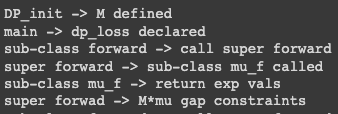

In [9]:
# What is M? 
M = torch.zeros(4, 4)
for i in range(4):
    j=i%2
    if j==0:
      M[i, i] = 1.0
      M[i, i+1] = -1.0
    else:
      M[i, i-1] = -1.0
      M[i, i] = 1.0
print(M)

tensor([[ 1., -1.,  0.,  0.],
        [-1.,  1.,  0.,  0.],
        [ 0.,  0.,  1., -1.],
        [ 0.,  0., -1.,  1.]])


fairTorch Descriptions:


**Equalized Odds:** This loss function ensures that the model produces similar false positive and false negative rates across different groups. Mathematically, it can be expressed as the sum of absolute differences between false positive rates and false negative rates across different groups.

**Demographic Parity:** This loss function ensures that the model produces similar probabilities of positive outcome across different groups. Mathematically, it can be expressed as the absolute difference between the probabilities of positive outcome for different groups.

**Calibration:** This loss function ensures that the model produces similar predicted probabilities of positive outcome and actual probabilities of positive outcome across different groups. Mathematically, it can be expressed as the sum of squared differences between predicted probabilities and actual probabilities of positive outcome across different groups.

**Bounded Group Loss:** This loss function ensures that the model produces similar performance for different groups while still achieving high overall performance. Mathematically, it can be expressed as a combination of accuracy and a group fairness metric, such as the difference between false positive rates or the difference between positive predictive values for different groups.
